# Problem 5.1: Solar Power - data reader

The following is a small program to read the data file "data_SolarPower.txt", which contains three columns: Year, cumulative solar power capacity (in MW), and Price (USD/Watt installed)

### Author & Date: 
- Troels C. Petersen (Niels Bohr Institute)
- 07-11-2021

***

In [1]:
import numpy as np                                     # Matlab like syntax for linear algebra and functions
import matplotlib.pyplot as plt                        # Plots and figures like you know them from Matlab
import seaborn as sns                                  # Make the plots nicer to look at
from iminuit import Minuit                             # The actual fitting tool, better than scipy's
import sys                                             # Module to see files and folders in directories
from scipy import stats
import random
from scipy.optimize import curve_fit

In [2]:
sys.path.append('D:\my github\Siyi Applied Stats\Documents for JN\AppStat2021-main\External_Functions\\')
from ExternalFunctions import UnbinnedLH, BinnedLH, Chi2Regression
from ExternalFunctions import nice_string_output, add_text_to_ax # useful functions to print fit results on figure

In [3]:
# Read the data and print it to check it:
import numpy as np

year, capacity, price = np.loadtxt("data_SolarPower.txt", skiprows=2, delimiter="\t", unpack=True)

print("Number of entries: ", len(year))
for i in range(len(year)) : 
    print(f"  {int(year[i]):4d}:  {capacity[i]:10.2f}   {price[i]:7.3f}")

Number of entries:  44
  1976:        0.30   106.100
  1977:        0.85    80.630
  1978:        1.80    56.230
  1979:        3.30    47.740
  1980:        6.50    35.010
  1981:       12.50    26.520
  1982:       20.00    22.280
  1983:       43.00    19.090
  1984:       67.00    16.970
  1985:       90.00    14.850
  1986:      120.00    11.140
  1987:      150.00     8.486
  1988:      175.00     7.532
  1989:      220.00     8.168
  1990:      270.00     8.805
  1991:      330.00     7.956
  1992:      400.00     7.213
  1993:      450.00     7.107
  1994:      500.00     6.365
  1995:      575.00     5.834
  1996:      700.00     6.046
  1997:      800.00     6.365
  1998:      975.00     5.728
  1999:     1250.00     5.092
  2000:     1500.00     4.879
  2001:     1750.00     4.773
  2002:     2300.00     4.031
  2003:     3000.00     3.978
  2004:     4300.00     4.137
  2005:     6000.00     4.243
  2006:     8500.00     4.455
  2007:    10300.00     4.137
  2008:    20000.

[1976. 1977. 1978. 1979. 1980. 1981. 1982. 1983. 1984. 1985. 1986. 1987.
 1988. 1989. 1990. 1991. 1992. 1993. 1994. 1995. 1996. 1997. 1998. 1999.
 2000. 2001. 2002. 2003. 2004. 2005. 2006. 2007. 2008. 2009. 2010. 2011.
 2012. 2013. 2014. 2015. 2016. 2017. 2018. 2019.] [3.00000e-01 8.50000e-01 1.80000e+00 3.30000e+00 6.50000e+00 1.25000e+01
 2.00000e+01 4.30000e+01 6.70000e+01 9.00000e+01 1.20000e+02 1.50000e+02
 1.75000e+02 2.20000e+02 2.70000e+02 3.30000e+02 4.00000e+02 4.50000e+02
 5.00000e+02 5.75000e+02 7.00000e+02 8.00000e+02 9.75000e+02 1.25000e+03
 1.50000e+03 1.75000e+03 2.30000e+03 3.00000e+03 4.30000e+03 6.00000e+03
 8.50000e+03 1.03000e+04 2.00000e+04 3.00000e+04 4.02790e+04 7.20340e+04
 1.01518e+05 1.35754e+05 1.71589e+05 2.17341e+05 2.91079e+05 3.83596e+05
 4.80984e+05 5.78553e+05]


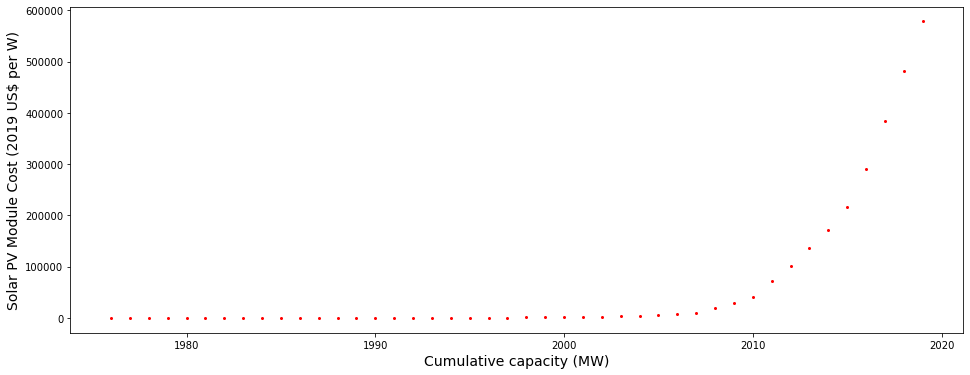

In [4]:
x = year
y = capacity
sy = np.empty(44)
erate_y = 0.45
'''
for j in range(0,44):
    sy[j] = y[j]*0.53   # error是sqrt(y)
'''
for j in range(0,44):
    sy[j] = y[j]*erate_y   # error是sqrt(y)


plt.figure(figsize=(16,6),facecolor='w')
plt.plot(x, y,'ro',markersize=2)
plt.xlabel('Cumulative capacity (MW)',fontsize=14)
plt.ylabel('Solar PV Module Cost (2019 US$ per W)',fontsize=14)

print(x,y)
#plt.savefig('fig1',dpi=600)
#fig.tight_layout()

In [5]:
def fit_pdf(x,a,b,c):    # 在指数函数的基础上增加一个c来移动横坐标的相对位置
    return a * np.exp(-b * (x-c))

'''
def fit_pdf(x, a, b,c):    # 在指数函数的基础上增加一个c来移动横坐标的相对位置
    return a * np.exp(b * (x-c))
'''

'\ndef fit_pdf(x, a, b,c):    # 在指数函数的基础上增加一个c来移动横坐标的相对位置\n    return a * np.exp(b * (x-c))\n'

In [6]:

Minuit.print_level = 1    # Print result of fits (generally - can also be moved down to each fit instance)

# Defining Chi2 calculation:
def chi2_owncalc(a,b,c) :
    y_fit = fit_pdf(x,a,b,c)
    chi2 = np.sum(((y - y_fit) / sy)**2)
    return chi2

# Alternatively, use the Chi2 regression from External Functions:
chi2fit = Chi2Regression(fit_pdf, x, y, sy)

minuit_chi2 = Minuit(chi2_owncalc,a=0.01,b=0.3,c=1950)
minuit_chi2.errordef = 1.0     # This is the definition for ChiSqaure fits
minuit_chi2.migrad()           # This is where the minimisation is carried out! Put ";" at the end to void output


┌─────────────────────────────────────────────────────────────────────────┐
│                                Migrad                                   │
├──────────────────────────────────┬──────────────────────────────────────┤
│ FCN = 59.71                      │              Nfcn = 236              │
│ EDM = 4.58e-08 (Goal: 0.0002)    │                                      │
├──────────────────────────────────┼──────────────────────────────────────┤
│          Valid Minimum           │        No Parameters at limit        │
├──────────────────────────────────┼──────────────────────────────────────┤
│ Below EDM threshold (goal x 10)  │           Below call limit           │
├───────────────┬──────────────────┼───────────┬─────────────┬────────────┤
│  Covariance   │     Hesse ok     │ Accurate  │  Pos. def.  │ Not forced │
└───────────────┴──────────────────┴───────────┴─────────────┴────────────┘
┌───┬──────┬───────────┬───────────┬────────────┬────────────┬─────────┬─────────┬───────┐
│   │ Name │   Value   │ Hesse Err │ Minos Err- │ Minos Err+ │ Limit-  │ Limit+  │ Fixed │
├───┼──────┼───────────┼───────────┼────────────┼────────────┼─────────┼─────────┼───────┤
│ 0 │ a    │   0.01    │   0.04    │            │            │         │         │       │
│ 1 │ b    │  -0.325   │   0.006   │            │            │         │         │       │
│ 2 │ c    │  1.963e3  │  0.014e3  │            │            │         │         │       │
└───┴──────┴───────────┴───────────┴────────────┴────────────┴─────────┴─────────┴───────┘
┌───┬────────────────────────────┐
│   │        a        b        c │
├───┼────────────────────────────┤
│ a │  0.00149 3.33e-05    0.552 │
│ b │ 3.33e-05 3.24e-05  0.00855 │
│ c │    0.552  0.00855      204 │
└───┴────────────────────────────┘

In [7]:

# First, check if the result was a valid minimum:
if (not minuit_chi2.fmin.is_valid) :
    print("  WARNING: The ChiSquare fit DID NOT converge!!! ")    
    
# Short hand way of accessing the fit parameters:
fit_a,fit_b,fit_c= minuit_chi2.values[:]   # The fitted values of the parameters

# Loop to get both parameter values and uncertainties:
for name in minuit_chi2.parameters :
    value, error = minuit_chi2.values[name], minuit_chi2.errors[name]
    print(f"Fit value: {name} = {value:.5f} +/- {error:.5f}")

# Get Chi2 value:
chi2_value = minuit_chi2.fval            # The value minimised, i.e. Chi2 or -2*LogLikeliHood (LLH) value

# Get number of degrees-of-freedom (Ndof):
N_NotEmptyBin = np.sum(y > 0)
Ndof_value = N_NotEmptyBin - minuit_chi2.nfit

Prob_value = stats.chi2.sf(chi2_value, Ndof_value) # The chi2 probability given N_DOF degrees of freedom
print(f"Chi2 value: {chi2_value:.1f}   Ndof = {Ndof_value:.0f}    Prob(Chi2,Ndof) = {Prob_value:5.3f}")


Fit value: a = 0.00826 +/- 0.03862
Fit value: b = -0.32512 +/- 0.00569
Fit value: c = 1962.77234 +/- 14.29749
Chi2 value: 59.7   Ndof = 41    Prob(Chi2,Ndof) = 0.030


' \n# 当error=relatively 0.53\nFit value: a = 0.00000 +/- 0.00000\nFit value: b = 0.32512 +/- 0.00698\nFit value: c = 1920.41147 +/- 16.19308\nChi2 value: 43.0   Ndof = 41    Prob(Chi2,Ndof) = 0.384\n'

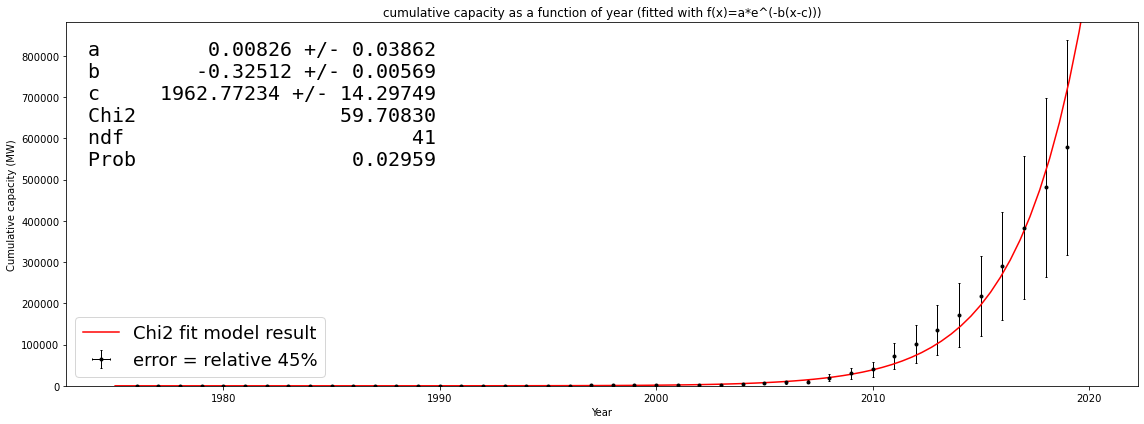

In [8]:

fig, ax = plt.subplots(figsize=(16, 6))  # figsize is in inches
ax.errorbar(x, y, yerr=sy, xerr=0.0, label='error = relative 45%', fmt='.k',  ecolor='k', elinewidth=1, capsize=1, capthick=1)

# Set the figure texts; xlabel, ylabel and title.
ax.set(xlabel="Year", # the label of the y axis
       ylabel="Cumulative capacity (MW)",  # the label of the y axis
       title="cumulative capacity as a function of year (fitted with f(x)=a*e^(-b(x-c)))", # the title of the plot
       ylim=[0.0,None]) # Setting the miminum to zero

xmin, xmax = 1975,2020
# Adding fit function to plot:
x_axis = np.linspace(xmin, xmax, 100)
ax.plot(x_axis, fit_pdf(x_axis, *minuit_chi2.values[:]), '-r', label='Chi2 fit model result') 

# Adding fit results to plot:
d = {'a': [minuit_chi2.values['a'], minuit_chi2.errors['a']],
     'b': [minuit_chi2.values['b'], minuit_chi2.errors['b']],
 #    'sigma':       [minuit_chi2.values['sigma'], minuit_chi2.errors['sigma']],
     'c': [minuit_chi2.values['c'], minuit_chi2.errors['c']],
     'Chi2':     chi2_value,
     'ndf':      Ndof_value,
     'Prob':     Prob_value,
    }

text = nice_string_output(d, extra_spacing=2, decimals=5)
add_text_to_ax(0.02, 0.95, text, ax, fontsize=20)
ax.legend(loc='lower left', fontsize=18); # could also be # loc = 'upper right' e.g.

fig.tight_layout()
plt.savefig('fig4',dpi=600)


''' 
# 当error=relatively 0.53
Fit value: a = 0.00000 +/- 0.00000
Fit value: b = 0.32512 +/- 0.00698
Fit value: c = 1920.41147 +/- 16.19308
Chi2 value: 43.0   Ndof = 41    Prob(Chi2,Ndof) = 0.384
'''